# Homework 4 - Convolutional Neural Networks 

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

### Question 2: Image Classification using CNN in Pytorch

#### a. Dataloader

In [91]:
def get_custom_data_loaders(batch_size=64, validation_size=0.1):
    x_train = np.load('x_train.npy')
    y_train = np.load('y_train.npy')
    x_test = np.load('x_test.npy')

    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=validation_size, random_state=42)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=torch.utils.data.SubsetRandomSampler(val_indices))
    test_loader = DataLoader(x_test_tensor, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


#### b.  Data Exploration

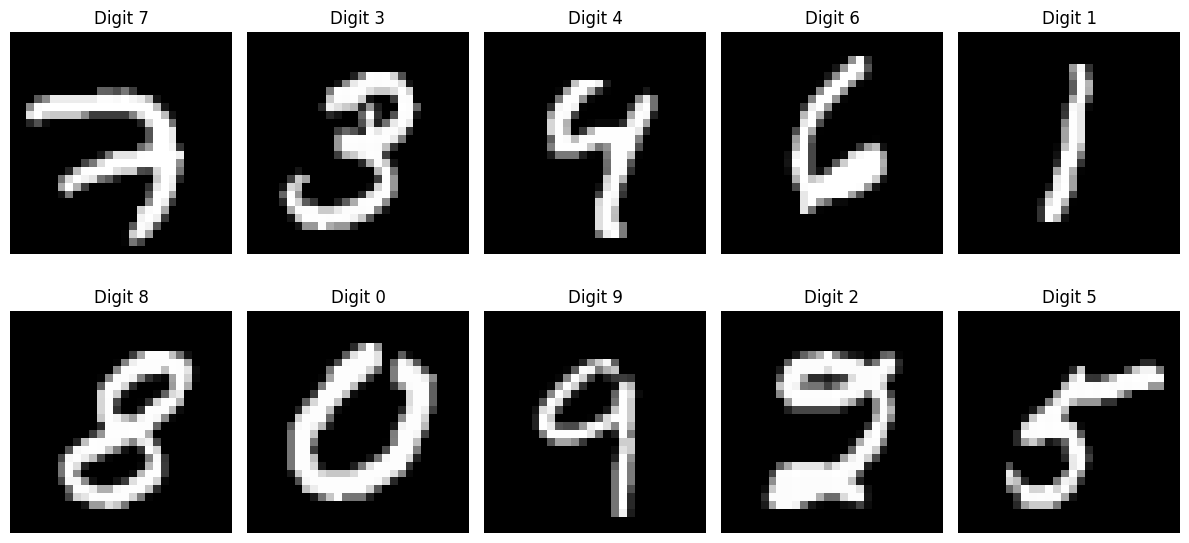

In [194]:

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

digit_examples = {}

for i in range(len(x_train)):
    digit = y_train[i]
    if digit not in digit_examples:
        digit_examples[digit] = x_train[i]

    if len(digit_examples) == 10:
        break

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.flatten()

for i, (digit, image) in enumerate(digit_examples.items()):
    image = image.reshape(28, 28)
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Digit {digit}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [195]:
y_train = np.load('y_train.npy')

samples_per_digit = {digit: np.sum(y_train == digit) for digit in range(10)}

print("Number of samples per digit:")
print(samples_per_digit)

balanced = all(samples_per_digit[digit] == samples_per_digit[0] for digit in range(1, 10))
if balanced:
    print("The data distribution is balanced.")
else:
    print("The data distribution is not balanced.")


Number of samples per digit:
{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
The data distribution is not balanced.


As observed from the count above for each of the digits, the number of images for each digit is not the same for all the digits. This indicates that the training dataset is unbalanced. But, all digits have the count in the range of 5000-6500 which means that the imbalance is very slight and not too much. 

#### c. Data Split

In [114]:
train_loader, val_loader, test_loader = get_custom_data_loaders(batch_size=64, validation_size=0.2)


#### d. Modeling

In [163]:

class CNN(nn.Module):
    def __init__(self, num_layers, activation, weight_decay, dropout_rate, filter_size, stride):
        super(CNN, self).__init__()
        self.num_layers = num_layers
        self.activation = activation
        self.weight_decay = weight_decay
        self.dropout = dropout_rate
        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for _ in range(num_layers):
            self.conv_layers.append(nn.Conv2d(in_channels, 32, kernel_size=filter_size, stride=stride, padding=1))
            in_channels = 32
        self.fc_input_size = 32 * (28 // (2 ** num_layers)) * (28 // (2 ** num_layers))
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout_layer = nn.Dropout(dropout_rate)

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = self.activation(conv_layer(x))
            x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, self.fc_input_size)
        x = self.activation(self.fc1(x))
        x = self.dropout_layer(x)
        x = self.fc2(x)
        return x


In [164]:
def initialize_parameters(num_layers, activation, dropout_rate, filter_size, stride, learning_rate, weight_decay):
    model = CNN(num_layers, activation, weight_decay, dropout_rate, filter_size, stride)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, criterion, optimizer


In [199]:
def train(model, criterion, optimizer, train_data, num_epochs):
    # Training 
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step: [{i+1}/{len(train_data)}], Loss: {loss.item():.4f}')
    
    #Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        print(f'Accuracy on the validation dataset: {100 * correct / total:.2f}%')


Testing the model with different hyperparameters like - learning rate, number of layers, activation, kernel size 

In [200]:
#Hyperparameters 
learning_rate = 0.01
num_epochs = 10

num_layers = 2  
filter_size=3
stride = 1
activation = nn.ReLU()
weight_decay= 0.001
dropout_rate = 0.5  

model, criterion, optimizer = initialize_parameters(num_layers, activation, dropout_rate, filter_size, stride, learning_rate, weight_decay)
model = train(model, criterion, optimizer, train_loader, num_epochs)

Epoch [1/10], Step: [100/750], Loss: 0.5240
Epoch [1/10], Step: [200/750], Loss: 0.3092
Epoch [1/10], Step: [300/750], Loss: 0.2318
Epoch [1/10], Step: [400/750], Loss: 0.2724
Epoch [1/10], Step: [500/750], Loss: 0.2824
Epoch [1/10], Step: [600/750], Loss: 0.1362
Epoch [1/10], Step: [700/750], Loss: 0.1360
Epoch [2/10], Step: [100/750], Loss: 0.0999
Epoch [2/10], Step: [200/750], Loss: 0.3065
Epoch [2/10], Step: [300/750], Loss: 0.1294
Epoch [2/10], Step: [400/750], Loss: 0.0813
Epoch [2/10], Step: [500/750], Loss: 0.1934
Epoch [2/10], Step: [600/750], Loss: 0.1838
Epoch [2/10], Step: [700/750], Loss: 0.2054
Epoch [3/10], Step: [100/750], Loss: 0.1265
Epoch [3/10], Step: [200/750], Loss: 0.2195
Epoch [3/10], Step: [300/750], Loss: 0.1676
Epoch [3/10], Step: [400/750], Loss: 0.1215
Epoch [3/10], Step: [500/750], Loss: 0.2888
Epoch [3/10], Step: [600/750], Loss: 0.1293
Epoch [3/10], Step: [700/750], Loss: 0.1341
Epoch [4/10], Step: [100/750], Loss: 0.2229
Epoch [4/10], Step: [200/750], L

In [184]:
#Hyperparameters 
learning_rate = 0.01
num_epochs = 10

num_layers = 2
filter_size=5
stride = 1
activation = nn.ReLU()
weight_decay= 0.01
dropout_rate = 0.5

model_2, criterion, optimizer = initialize_parameters(num_layers, activation, dropout_rate, filter_size, stride, learning_rate, weight_decay)
train(model_2, criterion, optimizer, train_loader, num_epochs)


Epoch [1/10], Step [100/750], Loss: 0.1994
Epoch [1/10], Step [200/750], Loss: 0.2558
Epoch [1/10], Step [300/750], Loss: 0.3195
Epoch [1/10], Step [400/750], Loss: 0.2122
Epoch [1/10], Step [500/750], Loss: 0.2196
Epoch [1/10], Step [600/750], Loss: 0.1329
Epoch [1/10], Step [700/750], Loss: 0.4931
Epoch [2/10], Step [100/750], Loss: 0.0850
Epoch [2/10], Step [200/750], Loss: 0.1579
Epoch [2/10], Step [300/750], Loss: 0.1467
Epoch [2/10], Step [400/750], Loss: 0.0883
Epoch [2/10], Step [500/750], Loss: 0.0742
Epoch [2/10], Step [600/750], Loss: 0.0468
Epoch [2/10], Step [700/750], Loss: 0.3965
Epoch [3/10], Step [100/750], Loss: 0.0920
Epoch [3/10], Step [200/750], Loss: 0.1149
Epoch [3/10], Step [300/750], Loss: 0.1360
Epoch [3/10], Step [400/750], Loss: 0.1015
Epoch [3/10], Step [500/750], Loss: 0.2311
Epoch [3/10], Step [600/750], Loss: 0.1222
Epoch [3/10], Step [700/750], Loss: 0.1006
Epoch [4/10], Step [100/750], Loss: 0.0816
Epoch [4/10], Step [200/750], Loss: 0.1828
Epoch [4/10

In [204]:
#Hyperparameters 
learning_rate = 0.001
num_epochs = 10

num_layers = 2
filter_size=3
stride = 1
activation = nn.Tanh()
weight_decay= 0.01
dropout_rate = 0.5

model_3, criterion, optimizer = initialize_parameters(num_layers, activation, dropout_rate, filter_size, stride, learning_rate, weight_decay)
model_3 = train(model_3, criterion, optimizer, train_loader, num_epochs)


Epoch [1/10], Step: [100/750], Loss: 0.5497
Epoch [1/10], Step: [200/750], Loss: 0.3358
Epoch [1/10], Step: [300/750], Loss: 0.1536
Epoch [1/10], Step: [400/750], Loss: 0.2626
Epoch [1/10], Step: [500/750], Loss: 0.1626
Epoch [1/10], Step: [600/750], Loss: 0.1488
Epoch [1/10], Step: [700/750], Loss: 0.2334
Epoch [2/10], Step: [100/750], Loss: 0.2395
Epoch [2/10], Step: [200/750], Loss: 0.2108
Epoch [2/10], Step: [300/750], Loss: 0.1122
Epoch [2/10], Step: [400/750], Loss: 0.1610
Epoch [2/10], Step: [500/750], Loss: 0.1159
Epoch [2/10], Step: [600/750], Loss: 0.1096
Epoch [2/10], Step: [700/750], Loss: 0.1829
Epoch [3/10], Step: [100/750], Loss: 0.1688
Epoch [3/10], Step: [200/750], Loss: 0.1908
Epoch [3/10], Step: [300/750], Loss: 0.2200
Epoch [3/10], Step: [400/750], Loss: 0.1932
Epoch [3/10], Step: [500/750], Loss: 0.2211
Epoch [3/10], Step: [600/750], Loss: 0.1046
Epoch [3/10], Step: [700/750], Loss: 0.1135
Epoch [4/10], Step: [100/750], Loss: 0.2103
Epoch [4/10], Step: [200/750], L

In [211]:
#Hyperparameters 
learning_rate = 0.001
num_epochs = 10

num_layers = 3
filter_size=3
stride = 1
activation = nn.ReLU()
weight_decay= 0.001
dropout_rate = 0.5  # Dropout rate

model_4, criterion, optimizer = initialize_parameters(num_layers, activation, dropout_rate, filter_size, stride, learning_rate, weight_decay)
train(model_4, criterion, optimizer, train_loader, num_epochs)


Epoch [1/10], Step: [100/750], Loss: 0.5510
Epoch [1/10], Step: [200/750], Loss: 0.3928
Epoch [1/10], Step: [300/750], Loss: 0.2141
Epoch [1/10], Step: [400/750], Loss: 0.1574
Epoch [1/10], Step: [500/750], Loss: 0.1420
Epoch [1/10], Step: [600/750], Loss: 0.3493
Epoch [1/10], Step: [700/750], Loss: 0.2818
Epoch [2/10], Step: [100/750], Loss: 0.0514
Epoch [2/10], Step: [200/750], Loss: 0.0752
Epoch [2/10], Step: [300/750], Loss: 0.1683
Epoch [2/10], Step: [400/750], Loss: 0.1560
Epoch [2/10], Step: [500/750], Loss: 0.1294
Epoch [2/10], Step: [600/750], Loss: 0.1386
Epoch [2/10], Step: [700/750], Loss: 0.0575
Epoch [3/10], Step: [100/750], Loss: 0.0690
Epoch [3/10], Step: [200/750], Loss: 0.1527
Epoch [3/10], Step: [300/750], Loss: 0.0931
Epoch [3/10], Step: [400/750], Loss: 0.0451
Epoch [3/10], Step: [500/750], Loss: 0.0444
Epoch [3/10], Step: [600/750], Loss: 0.0477
Epoch [3/10], Step: [700/750], Loss: 0.2116
Epoch [4/10], Step: [100/750], Loss: 0.0188
Epoch [4/10], Step: [200/750], L

In [214]:
#Hyperparameters 
learning_rate = 0.01
num_epochs = 10

num_layers = 2
filter_size=3
stride = 1
activation = nn.Tanh()
weight_decay= 0.01
dropout_rate = 0.5

model_5, criterion, optimizer = initialize_parameters(num_layers, activation, dropout_rate, filter_size, stride, learning_rate, weight_decay)
train(model_5, criterion, optimizer, train_loader, num_epochs)


Epoch [1/10], Step: [100/750], Loss: 0.7476
Epoch [1/10], Step: [200/750], Loss: 0.3316
Epoch [1/10], Step: [300/750], Loss: 0.2834
Epoch [1/10], Step: [400/750], Loss: 0.2770
Epoch [1/10], Step: [500/750], Loss: 0.2884
Epoch [1/10], Step: [600/750], Loss: 0.3668
Epoch [1/10], Step: [700/750], Loss: 0.3576
Epoch [2/10], Step: [100/750], Loss: 0.3477
Epoch [2/10], Step: [200/750], Loss: 0.3305
Epoch [2/10], Step: [300/750], Loss: 0.3572
Epoch [2/10], Step: [400/750], Loss: 0.4182
Epoch [2/10], Step: [500/750], Loss: 0.3373
Epoch [2/10], Step: [600/750], Loss: 0.1983
Epoch [2/10], Step: [700/750], Loss: 0.5241
Epoch [3/10], Step: [100/750], Loss: 0.2855
Epoch [3/10], Step: [200/750], Loss: 0.3438
Epoch [3/10], Step: [300/750], Loss: 0.2282
Epoch [3/10], Step: [400/750], Loss: 0.3803
Epoch [3/10], Step: [500/750], Loss: 0.3434
Epoch [3/10], Step: [600/750], Loss: 0.3367
Epoch [3/10], Step: [700/750], Loss: 0.3527
Epoch [4/10], Step: [100/750], Loss: 0.2090
Epoch [4/10], Step: [200/750], L

After experimenting with different hyperparameters such as learning rate, num_layers, activation and kernel_size, it is observed that model_4 gives the highest accuracy with the validation accuracy score of 98.57% 
The hyperparameters for this model were as follows - 

learning_rate = 0.001

num_epochs = 10

num_layers = 3

filter_size=3

stride = 1

activation = ReLU

weight_decay= 0.001

dropout_rate = 0.5 


#### g. Inference

In [217]:

model_4.eval()

predictions = []

for images in test_loader:
    
    with torch.no_grad():
        images = images.view(-1, 1, 28, 28)
        outputs = model_4(images)
    
    _, predicted = torch.max(outputs, 1)
    
    predictions.extend(predicted.cpu().numpy())

predictions_df = pd.DataFrame(predictions, columns=['pred_cnn'])

predictions_df.to_csv('Neha_Manghnani_Preds.csv', index=False)


#### (BONUS) Filter Visualization

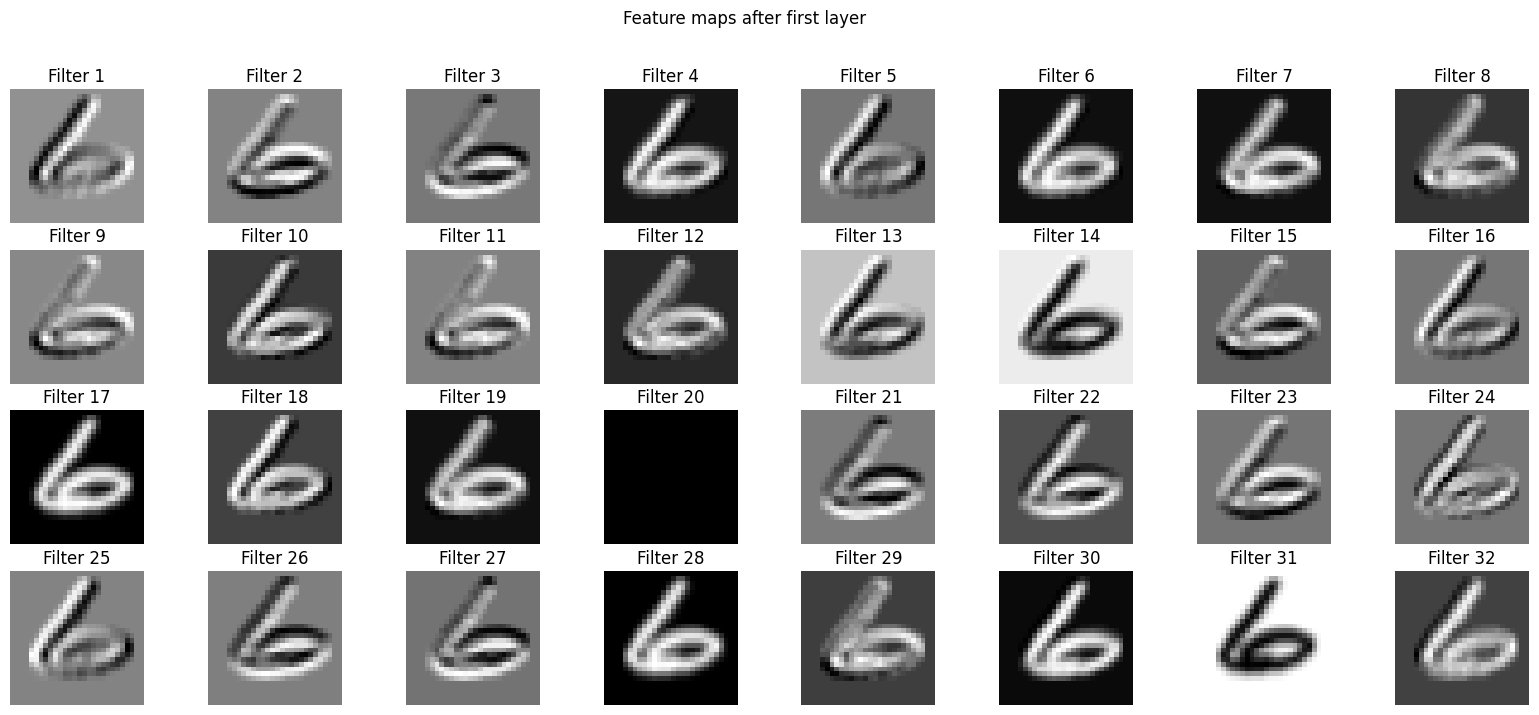

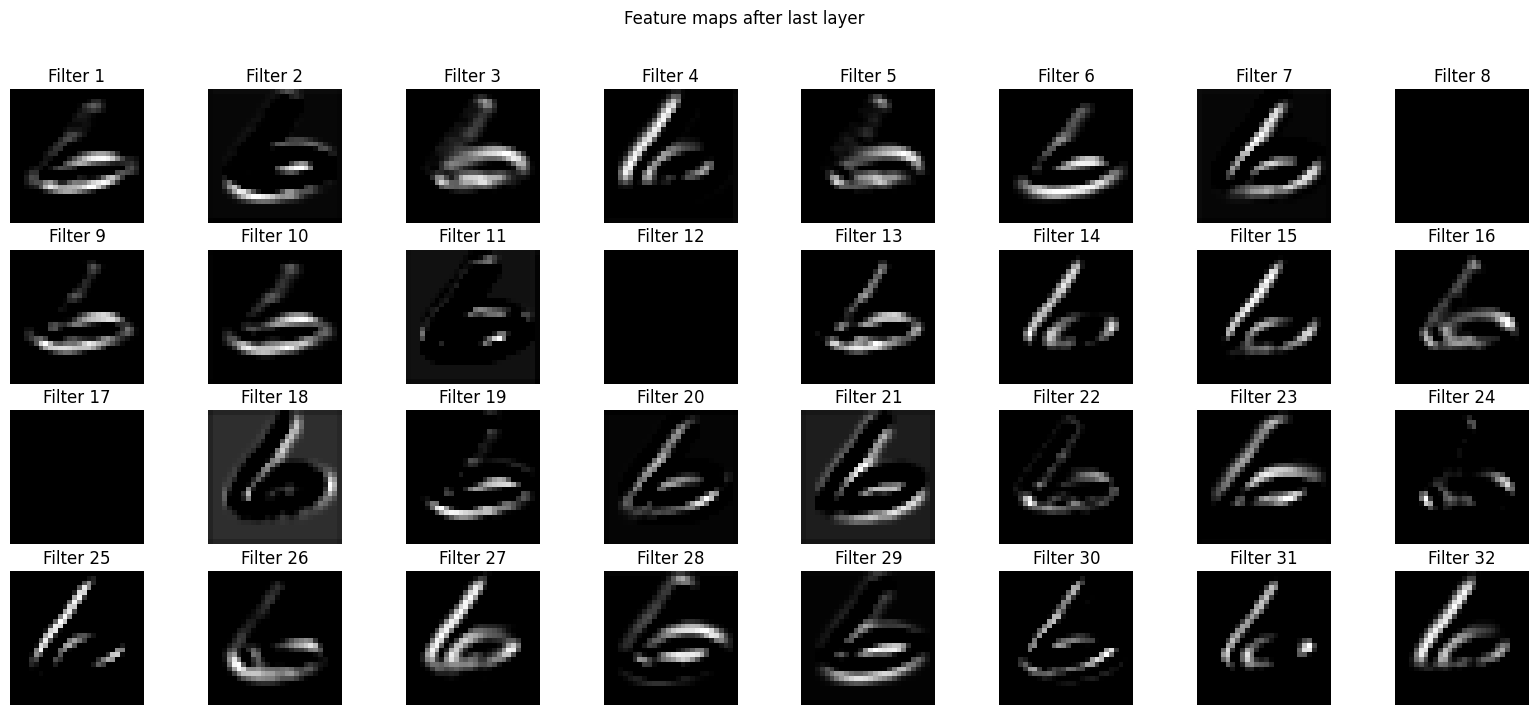

In [183]:
model_4.eval()

image, _ = next(iter(train_loader))

with torch.no_grad():
    image = image.view(-1, 1, 28, 28)
    output_first_conv = model_4.conv_layers[0](image)
    
    for conv_layer in model_4.conv_layers[:-1]:
        image = model_4.activation(conv_layer(image))
    output_last_conv = image

def visualize_feature_maps(feature_maps, layer_name):
    num_filters = feature_maps.shape[1]
    plt.figure(figsize=(20, 8))
    for i in range(num_filters):
        plt.subplot(4, num_filters // 4, i + 1)
        plt.imshow(feature_maps[0, i].cpu(), cmap='gray')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle(f'Feature maps after {layer_name} layer')
    plt.show()

visualize_feature_maps(output_first_conv, 'first')
visualize_feature_maps(output_last_conv, 'last')
